In [35]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt

# 1. Se connecter à l'API
api = wandb.Api()

# 2. Charger le sweep
# Remplace 'entity', 'project' et 'SWEEP_ID' par tes infos
sweep = api.sweep("qberal-insa-rouen/puma/p0sldrvb")

# 3. Pour chaque run, récupérer l'historique des métriques
all_runs = []
runs_info = {}
for run in sweep.runs:
    # Choisis les clés qui t'intéressent, ex. 'train_loss', 'val_loss', 'val_accuracy'
    df = run.history(pandas=True)
    # Ajouter l'ID de la run au DataFrame
    df['run_id'] = run.id
    all_runs.append(df)
    # Stocker les informations sur chaque run
    runs_info[run.id] = {
        'name': run.name,
        'summary': run.summary._json_dict if hasattr(run.summary, '_json_dict') else {}
    }

# 4. Concaténer toutes les courbes
df_all = pd.concat(all_runs, ignore_index=True)



In [36]:
df_all.head() # Afficher les premières lignes pour vérifier les colonnes

,run_id,F1-Score/Validation,_runtime,_timestamp,F1-Score/Train,AUROC/Validation,Accuracy-Score/Train,AUROC/Train,Loss/Validation,Average-Precision/Validation,Average-Precision/Train,Accuracy-Score/Validation,Learning-Rate/Learning-Rate,_step,Loss/Train
0,nwfntjys,0.744207,254.862911,1.745745e+09,0.756816,0.896707,0.756816,0.866915,0.883154,0.375073,0.354106,0.744207,0.000074,1.0,0.856601
1,nwfntjys,0.743648,257.196823,1.745745e+09,0.814963,0.912705,0.814963,0.943210,0.853647,0.402722,0.524792,0.743648,0.000070,2.0,0.622680
2,nwfntjys,0.756603,260.375209,1.745745e+09,0.832345,0.919342,0.832345,0.956060,0.833707,0.416961,0.588725,0.756603,0.000066,3.0,0.553255
3,nwfntjys,0.751912,262.300955,1.745745e+09,0.842998,0.920925,0.842998,0.964744,0.834690,0.422810,0.635189,0.751912,0.000063,4.0,0.508808
4,nwfntjys,0.751019,264.418944,1.745745e+09,0.851776,0.923233,0.851776,0.969337,0.828203,0.428273,0.664458,0.751019,0.000060,5.0,0.473661


In [37]:
# Afficher les informations sur toutes les runs disponibles
print("Informations sur les runs disponibles:")
run_ids = df_all['run_id'].unique()
run_info_table = []

for run_id in run_ids:
    run_df = df_all[df_all['run_id'] == run_id]
    
    # Calculer les métriques finales et le comportement de la loss
    metrics = {}
    for metric in ['AUROC/Validation', 'F1-Score/Validation', 'Loss/Validation']:
        if metric in run_df.columns:
            metrics[metric] = run_df[metric].iloc[-1]  # Dernière valeur
    
    # Détecter le surapprentissage en regardant si la loss remonte sur la seconde moitié
    overfitting = False
    if 'Loss/Validation' in run_df.columns:
        half_point = len(run_df) // 2
        if half_point > 5:  # Assez de points pour l'analyse
            first_half_min = run_df['Loss/Validation'].iloc[:half_point].min()
            second_half_min = run_df['Loss/Validation'].iloc[half_point:].min()
            final_loss = run_df['Loss/Validation'].iloc[-1]
            overall_min = run_df['Loss/Validation'].min()
            
            # Si la loss finale est plus de 5% supérieure au minimum global
            overfitting = final_loss > overall_min * 1.05
    
    # Ajouter les informations à la table
    run_info = {
        'run_id': run_id,
        'name': runs_info[run_id]['name'] if run_id in runs_info else '',
        **metrics,
        'overfitting': "Oui" if overfitting else "Non"
    }
    run_info_table.append(run_info)

# Créer un DataFrame pour un affichage plus clair
runs_summary = pd.DataFrame(run_info_table)
if not runs_summary.empty:
    # Réorganiser les colonnes pour une meilleure lecture
    cols = ['run_id', 'name', 'overfitting']
    metric_cols = [col for col in runs_summary.columns if col not in ['run_id', 'name', 'overfitting']]
    cols.extend(metric_cols)
    runs_summary = runs_summary[cols]
    display(runs_summary.sort_values(by='AUROC/Validation', ascending=False))
else:
    print("Aucune information sur les runs n'est disponible.")

Informations sur les runs disponibles:


,run_id,name,overfitting,AUROC/Validation,F1-Score/Validation,Loss/Validation
0,nwfntjys,2025-04-27T110223_CellViT-SAM-H Sweep Run,Oui,0.932341,0.767938,0.917050
3,chdjzdx2,2025-04-27T104554_CellViT-SAM-H Sweep Run,Oui,0.932319,0.770060,0.921078
5,078chyd7,2025-04-27T103343_CellViT-SAM-H Sweep Run,Oui,0.932285,0.770283,0.908352
4,0fsuwloa,2025-04-27T103943_CellViT-SAM-H Sweep Run,Oui,0.932031,0.769557,0.883279
2,4m2lay4y,2025-04-27T105124_CellViT-SAM-H Sweep Run,Oui,0.931633,0.771958,0.929039
...,...,...,...,...,...,...
63,8hxr63nr,2025-04-27T044144_CellViT-SAM-H Sweep Run,Non,0.927131,0.762633,0.810091
94,p0yxtijm,2025-04-27T013126_CellViT-SAM-H Sweep Run,Oui,0.925306,0.759897,0.980994
6,3mnixoat,2025-04-27T102728_CellViT-SAM-H Sweep Run,Non,0.917163,0.758390,0.828052
51,ruas7cpa,2025-04-27T055444_CellViT-SAM-H Sweep Run,Oui,0.916808,0.760679,1.227413


In [38]:
# Afficher les IDs de toutes les runs disponibles pour faciliter la sélection manuelle
print("👇 Liste des IDs de runs disponibles pour la sélection manuelle:")
print("=" * 60)
run_ids_list = df_all['run_id'].unique()
for i, run_id in enumerate(run_ids_list):
    run_name = runs_info[run_id]['name'] if run_id in runs_info else 'N/A'
    print(f"{i+1}. ID: {run_id} | Nom: {run_name}")
print("=" * 60)
print("Pour sélectionner une run spécifique, copiez son ID dans la variable selected_run_id ci-dessous")

👇 Liste des IDs de runs disponibles pour la sélection manuelle:
1. ID: nwfntjys | Nom: 2025-04-27T110223_CellViT-SAM-H Sweep Run
2. ID: 6g5dzq7r | Nom: 2025-04-27T105658_CellViT-SAM-H Sweep Run
3. ID: 4m2lay4y | Nom: 2025-04-27T105124_CellViT-SAM-H Sweep Run
4. ID: chdjzdx2 | Nom: 2025-04-27T104554_CellViT-SAM-H Sweep Run
5. ID: 0fsuwloa | Nom: 2025-04-27T103943_CellViT-SAM-H Sweep Run
6. ID: 078chyd7 | Nom: 2025-04-27T103343_CellViT-SAM-H Sweep Run
7. ID: 3mnixoat | Nom: 2025-04-27T102728_CellViT-SAM-H Sweep Run
8. ID: 55yzu08r | Nom: 2025-04-27T102159_CellViT-SAM-H Sweep Run
9. ID: 9m60hjns | Nom: 2025-04-27T101554_CellViT-SAM-H Sweep Run
10. ID: 5ok3h19o | Nom: 2025-04-27T100923_CellViT-SAM-H Sweep Run
11. ID: dhsdl1bj | Nom: 2025-04-27T100312_CellViT-SAM-H Sweep Run
12. ID: nj5848m5 | Nom: 2025-04-27T095651_CellViT-SAM-H Sweep Run
13. ID: nw7eikev | Nom: 2025-04-27T095035_CellViT-SAM-H Sweep Run
14. ID: ftmtg7cn | Nom: 2025-04-27T094414_CellViT-SAM-H Sweep Run
15. ID: csyk8vqr | No

In [42]:
# Sélection de la meilleure run basée sur un équilibre entre performance et surapprentissage
# Nous allons privilégier les runs sans surapprentissage

# Fonction pour trouver la meilleure run équilibrée
def find_best_balanced_run(df_all, runs_summary):
    if runs_summary.empty:
        return df_all['run_id'].iloc[0] if not df_all.empty else None
    
    # D'abord essayer de trouver les runs sans surapprentissage
    no_overfitting = runs_summary[runs_summary['overfitting'] == "Non"]
    
    if not no_overfitting.empty and 'AUROC/Validation' in no_overfitting.columns:
        # Parmi les runs sans surapprentissage, prendre celle avec le meilleur AUROC
        best_run_id = no_overfitting.sort_values(by='AUROC/Validation', ascending=False)['run_id'].iloc[0]
        print(f"✅ Meilleure run sans surapprentissage: {best_run_id}")
        if best_run_id in runs_info:
            print(f"✅ Nom: {runs_info[best_run_id]['name']}")
        return best_run_id
    else:
        # Sinon, prendre la run avec le meilleur AUROC parmi toutes
        if 'AUROC/Validation' in runs_summary.columns:
            best_run_id = runs_summary.sort_values(by='AUROC/Validation', ascending=False)['run_id'].iloc[0]
            print(f"⚠️ Toutes les runs montrent du surapprentissage. Meilleure run par AUROC: {best_run_id}")
            if best_run_id in runs_info:
                print(f"⚠️ Nom: {runs_info[best_run_id]['name']}")
            return best_run_id
        else:
            # Fallback si pas de métrique AUROC
            best_run_id = runs_summary['run_id'].iloc[0]
            print(f"⚠️ Impossible de déterminer la meilleure run. Utilisation de: {best_run_id}")
            return best_run_id

# CHOISIR UNE RUN SPÉCIFIQUE:
# Pour sélectionner manuellement une run, décommentez et remplacez None par l'ID de la run désirée
# (copiez un ID depuis la liste de runs ci-dessus)
selected_run_id = None
#selected_run_id = "p0yxtijm"  # Exemple: remplacez par un ID réel de la liste

if selected_run_id and selected_run_id in df_all['run_id'].unique():
    best_run_id = selected_run_id
    print(f"🔵 Run sélectionnée manuellement: {best_run_id}")
    if best_run_id in runs_info:
        print(f"🔵 Nom: {runs_info[best_run_id]['name']}")
else:
    if selected_run_id:
        print(f"⚠️ L'ID '{selected_run_id}' n'existe pas dans les runs disponibles!")
    best_run_id = find_best_balanced_run(df_all, runs_summary)

# Filtrer le DataFrame pour ne garder que la meilleure run
df_best_run = df_all[df_all['run_id'] == best_run_id].copy()

✅ Meilleure run sans surapprentissage: 6bbkjoqw
✅ Nom: 2025-04-27T073139_CellViT-SAM-H Sweep Run


🔍 Affichage de toutes les courbes pour chaque métrique:


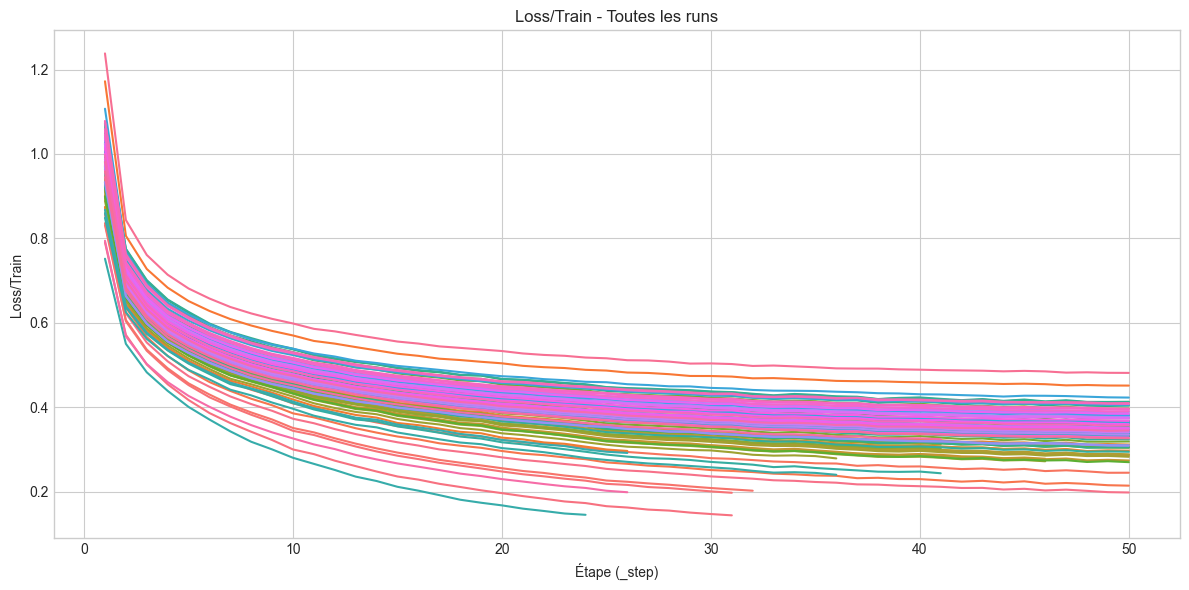

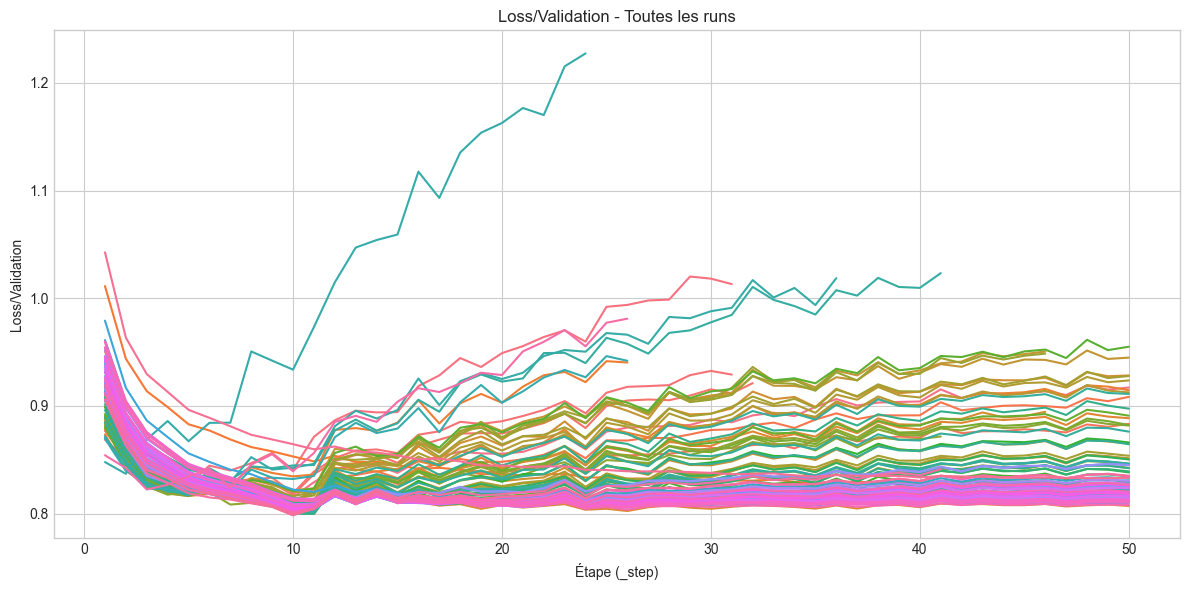

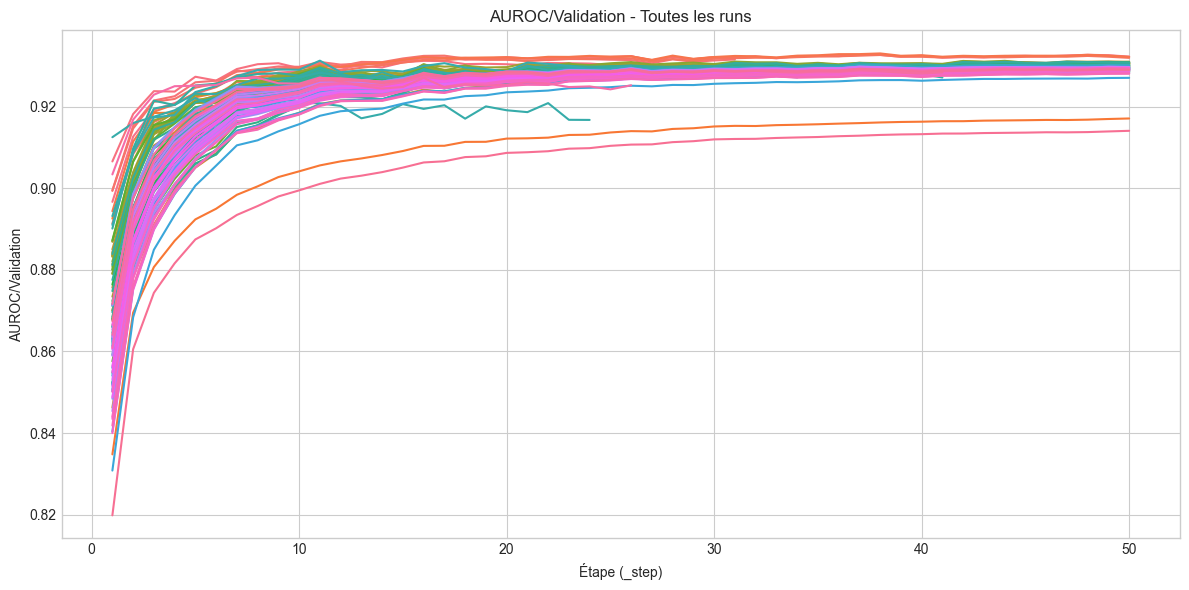

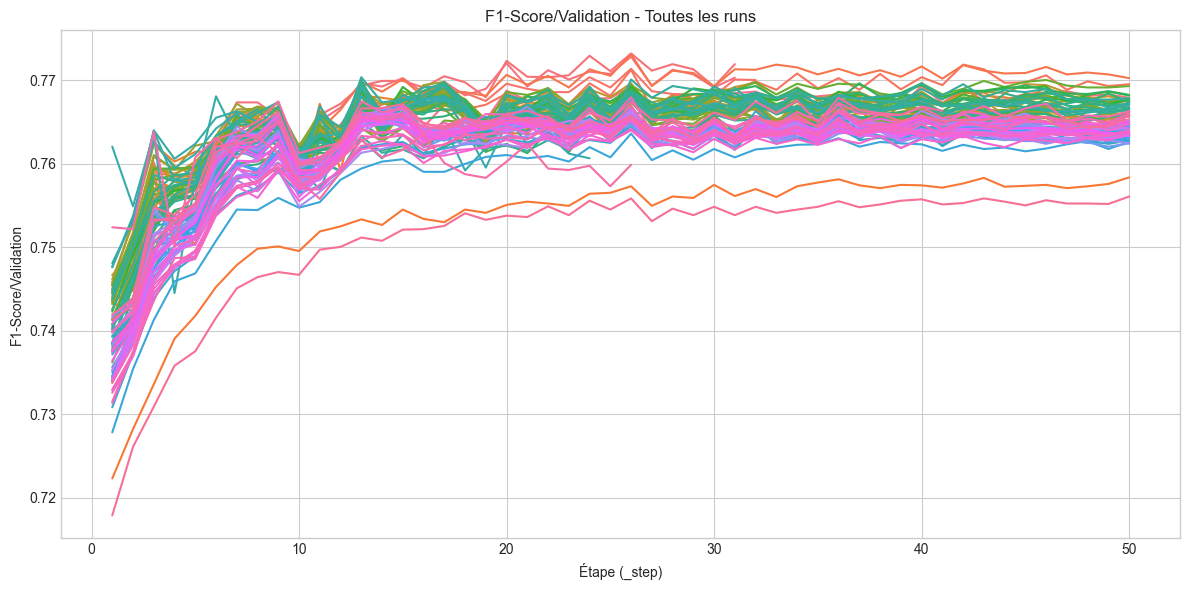

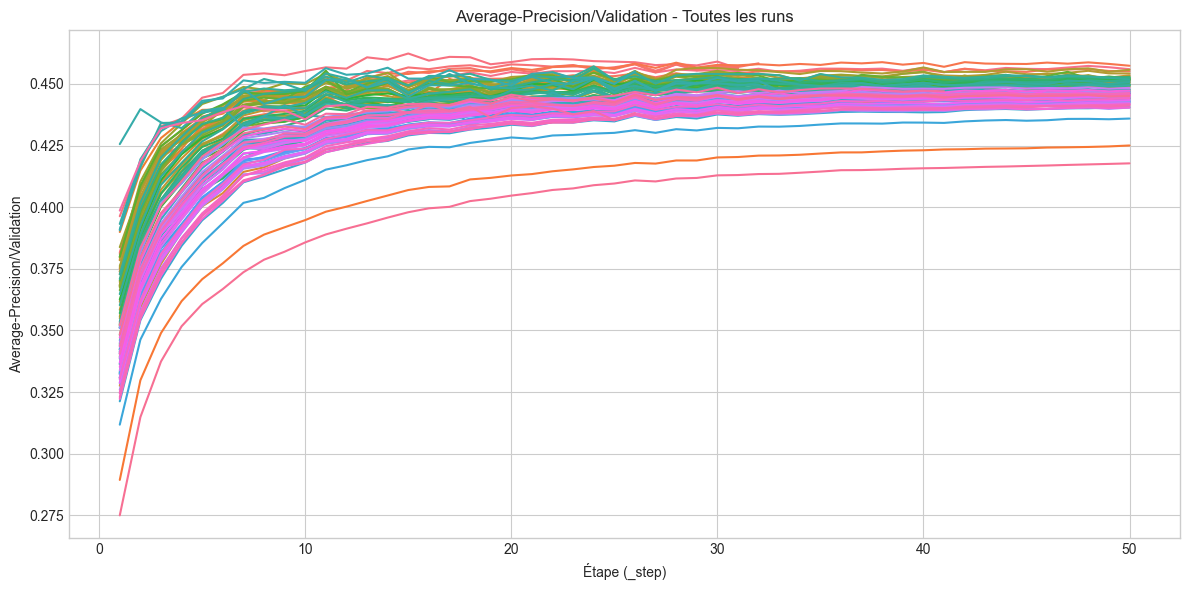

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns # Pour une meilleure esthétique des plots

# Liste des métriques à tracer
metrics_to_plot = [
    'Loss/Train',
    'Loss/Validation',
    'AUROC/Validation',
    'F1-Score/Validation',
    'Average-Precision/Validation'
]

# Assurer que la colonne _step existe et est utilisable comme axe x
# Si _step n'est pas la bonne colonne pour l'axe x, ajuste ici (ex: df_all.index)
if '_step' not in df_all.columns:
    print("La colonne '_step' n'existe pas, utilisation de l'index comme axe X.")
    x_axis = df_all.index
else:
    x_axis = '_step'

plt.style.use('seaborn-v0_8-whitegrid') # Style de graphique

print("🔍 Affichage de toutes les courbes pour chaque métrique:")

for metric in metrics_to_plot:
    if metric in df_all.columns:
        plt.figure(figsize=(12, 6))
        # Utiliser seaborn pour tracer les lignes avec une couleur par run_id, sans légende
        sns.lineplot(data=df_all, x=x_axis, y=metric, hue='run_id', legend=False)
        plt.title(f'{metric} - Toutes les runs')
        plt.xlabel('Étape (_step)')
        plt.ylabel(metric)
        
        plt.tight_layout() # Ajuster le layout
        plt.show()
    else:
        print(f"La métrique '{metric}' n'a pas été trouvée dans le DataFrame.")

🌟 Affichage des courbes pour la meilleure run uniquement:


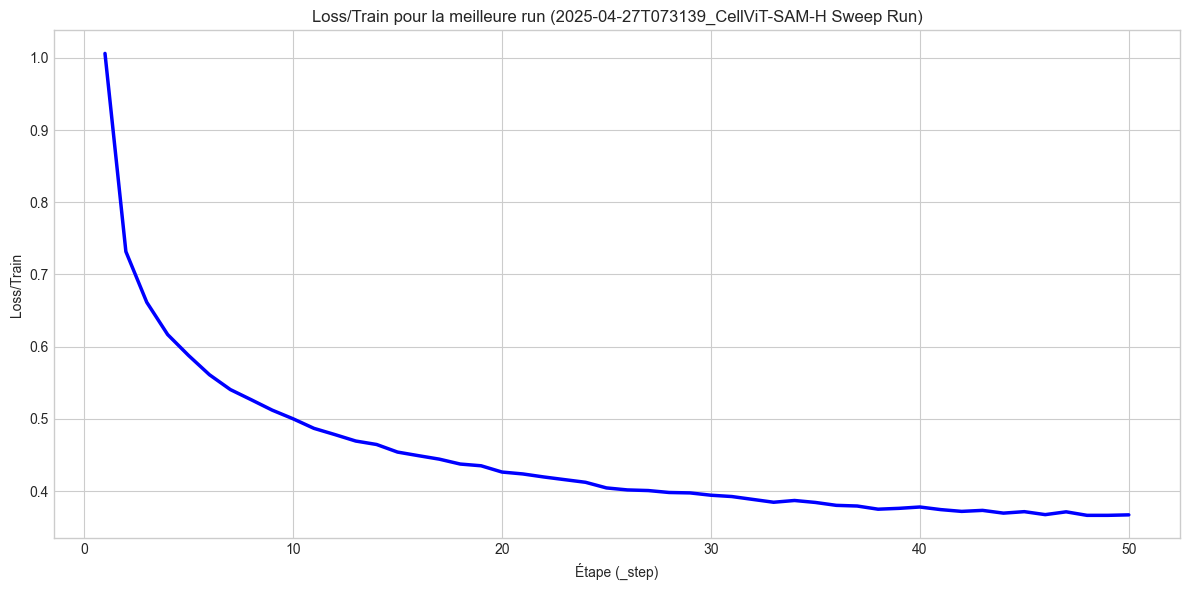

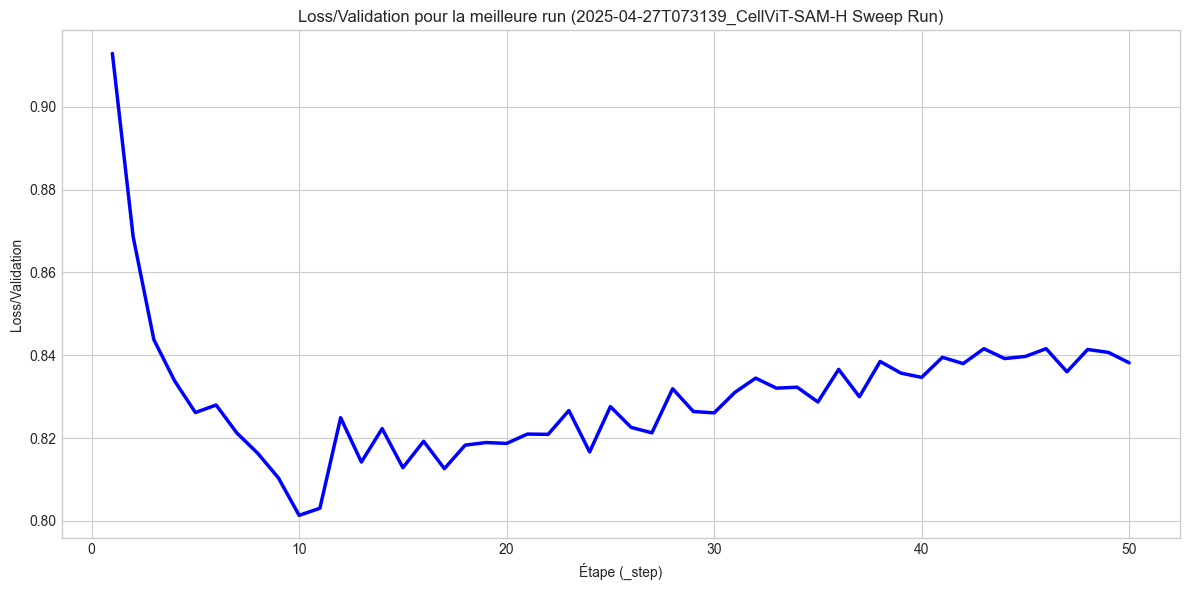

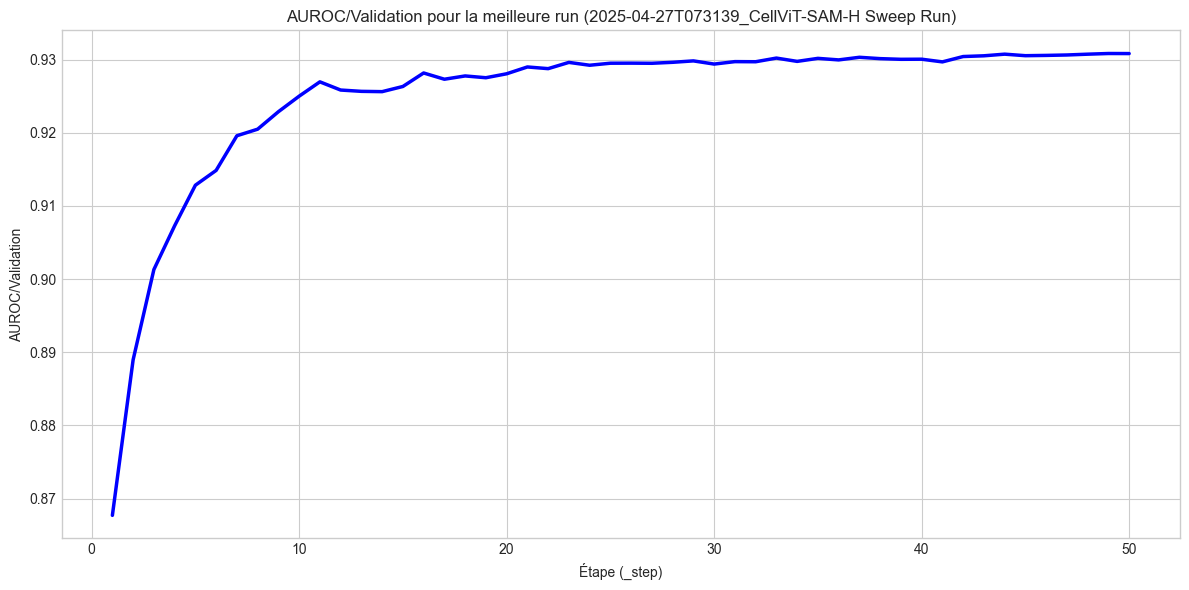

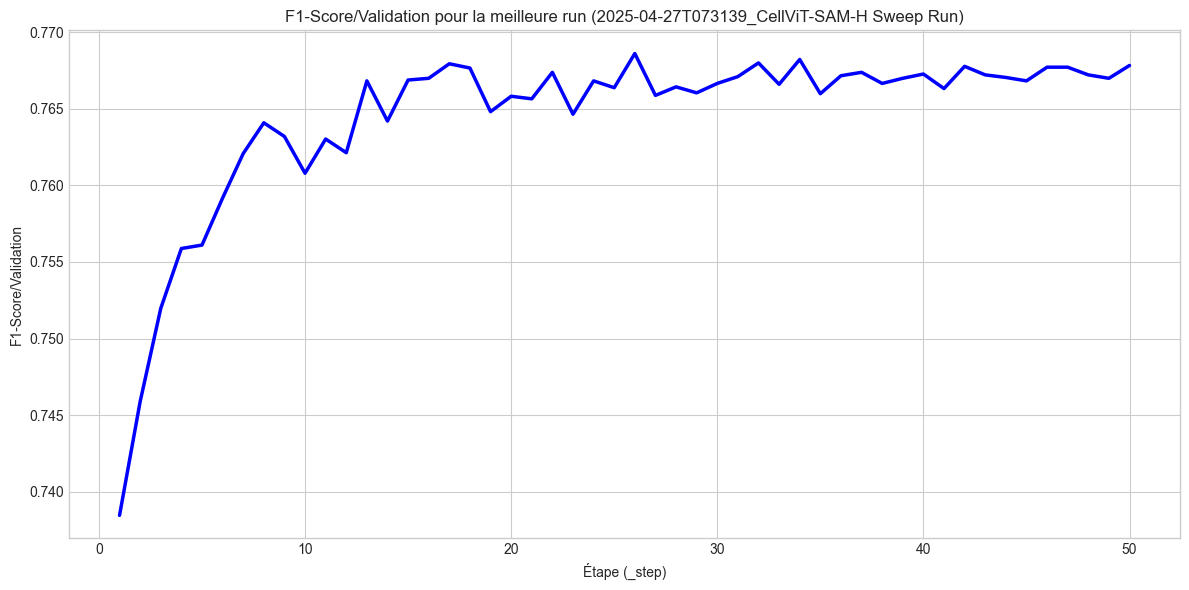

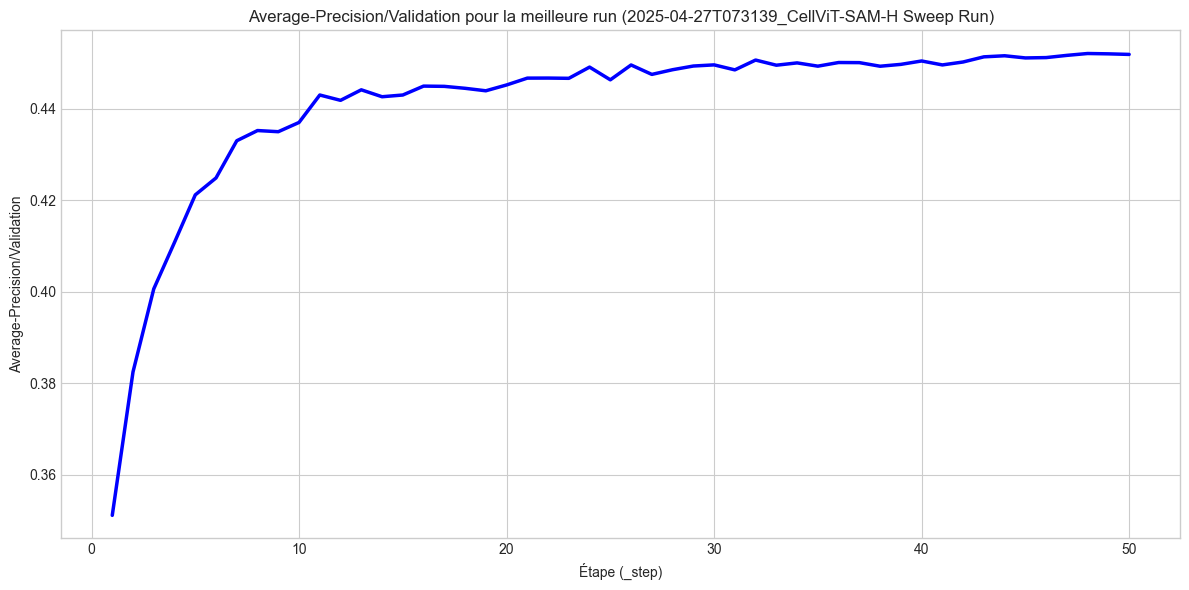

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns # Pour une meilleure esthétique des plots

# Liste des métriques à tracer
metrics_to_plot = [
    'Loss/Train',
    'Loss/Validation',
    'AUROC/Validation',
    'F1-Score/Validation',
    'Average-Precision/Validation'
]

# Assurer que la colonne _step existe et est utilisable comme axe x
# Si _step n'est pas la bonne colonne pour l'axe x, ajuste ici (ex: df_all.index)
if '_step' not in df_best_run.columns:
    print("La colonne '_step' n'existe pas, utilisation de l'index comme axe X.")
    x_axis = df_best_run.index
else:
    x_axis = '_step'

plt.style.use('seaborn-v0_8-whitegrid') # Style de graphique

print("🌟 Affichage des courbes pour la meilleure run uniquement:")

for metric in metrics_to_plot:
    if metric in df_best_run.columns:
        plt.figure(figsize=(12, 6))
        # Utiliser lineplot pour tracer uniquement la meilleure run (pas besoin de hue puisqu'une seule run)
        sns.lineplot(data=df_best_run, x=x_axis, y=metric, color='blue', linewidth=2.5)
        plt.title(f"{metric} pour la meilleure run ({runs_info[best_run_id]['name'] if best_run_id in runs_info else best_run_id})")
        plt.xlabel('Étape (_step)')
        plt.ylabel(metric)
        
        plt.tight_layout() # Ajuster le layout
        plt.show()
    else:
        print(f"La métrique '{metric}' n'a pas été trouvée dans le DataFrame.")

<bound method Sweep.best_run of <Sweep qberal-insa-rouen/puma/p0sldrvb (RUNNING)>>